Transfer-based attack method adapted from https://dl.acm.org/doi/pdf/10.1145/3460120.3484575

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
import numpy as np

from torch.nn import functional as F
from torch import nn, optim
from torch.utils.data import TensorDataset
from torch_geometric.loader import DataLoader as GDataLoader
from torch_geometric.data import Dataset
from torch_geometric.datasets import TUDataset
from sklearn.metrics import roc_auc_score
from sklearn.utils.class_weight import compute_class_weight
from sklearn.preprocessing import OneHotEncoder

from ml_util import CustomGraphDataset, CustomGATModel, train_model_multi_graph, train_model, load_model, predict, predict_multi_graph, get_auroc_score
from util import onehot_transform, graph_train_test_split, create_perturbed_graphs
from train_models import get_dataset, shadow_target_split, train_gat

In [3]:
x = torch.Tensor([[1,0]])
y = torch.Tensor([[0,1]])
F.cross_entropy(x,y)

tensor(1.3133)

In [4]:
DEVICE = ('cuda:0' if torch.cuda.is_available() else 'cpu')

In [5]:
dataset_name = 'PROTEINS'

dataset = get_dataset(dataset_name) 
num_feat = dataset[0].x.shape[1]
num_categories = dataset[0].y.shape[1]
t_dataset_train, t_dataset_test, s_dataset_train, s_dataset_test = shadow_target_split(dataset, target_test_size=0.2, shadow_test_size=0.2)

In [6]:
t_model, t_save_path = train_gat(dataset_name, 't', t_dataset_train, t_dataset_test, device=DEVICE)

Learning rate: 0.001
No learning rate scheduling!
Training for 200 epochs, with batch size=8
Using validation data (112 samples)
Using device: cuda:0
Saving model every 10 epochs to mia-models/t_model_gat_PROTEINS.pth

-----Epoch 1/200-----
Batch 10/56 | loss: 0.69638 (0.342s) | train acc: 0.588 | train AUC: 0.522
Batch 20/56 | loss: 0.71917 (0.068s) | train acc: 0.613 | train AUC: 0.490
Batch 30/56 | loss: 0.67527 (0.068s) | train acc: 0.613 | train AUC: 0.531
Batch 40/56 | loss: 0.65190 (0.069s) | train acc: 0.606 | train AUC: 0.550
Batch 50/56 | loss: 0.68499 (0.068s) | train acc: 0.593 | train AUC: 0.548
Batch 56/56 | loss: 0.73121 (0.041s) | train acc: 0.588 | train AUC: 0.545
Validation: val loss: 0.706 | val acc: 0.661 | val F1: 0.387 | val AUC: 0.498

-----Epoch 2/200-----
Batch 10/56 | loss: 0.66020 (0.064s) | train acc: 0.675 | train AUC: 0.571
Batch 20/56 | loss: 0.70427 (0.064s) | train acc: 0.619 | train AUC: 0.559
Batch 30/56 | loss: 0.70032 (0.065s) | train acc: 0.596 | 

In [7]:
# Predicted labels for the shadow dataset being passed to the target model
# t_shadow_pred = predict_multi_graph(t_model, s_dataset, device=DEVICE, logits=True, return_type='pt')
# t_shadow_pred = F.one_hot(t_shadow_pred.argmax(dim=1), num_classes=num_categories).to(torch.float32)

# Predicted labels for the target training dataset
# t_target_pred = predict_multi_graph(t_model, t_dataset_train, device=DEVICE, logits=True, return_type='pt')
# t_target_pred = F.one_hot(t_target_pred.argmax(dim=1), num_classes=num_categories).to(torch.float32)

In [8]:
def relabel_dataset(t_model, s_dataset, device='cpu'):
    '''
    Re-label the shadow dataset with the target model's predictions
    '''
    num_categories = s_dataset[0].y.shape[1]
    t_shadow_pred = predict_multi_graph(t_model, s_dataset, device=device, logits=True, return_type='pt')
    t_shadow_pred = F.one_hot(t_shadow_pred.argmax(dim=1), num_classes=num_categories).to(torch.float32)
    
    data_list = []
    for i,g in enumerate(s_dataset):
        g.y = t_shadow_pred[i].unsqueeze(0)
        data_list.append(g)
    relabeled_s_dataset = CustomGraphDataset(data_list)
    return relabeled_s_dataset


In [9]:
relabeled_s_dataset_train = relabel_dataset(t_model, s_dataset_train, device=DEVICE)
relabeled_s_dataset_test = relabel_dataset(t_model, s_dataset_test, device=DEVICE)

In [10]:
model_params = {
    'heads': 4, 
    'layers': 2, 
    'hidden_dim': 18, 
    'out_dim': 144, 
    'batch_norm': True, 
    'dropout': 0.4
}

In [11]:
s_model, s_save_path = train_gat(dataset_name, 's', relabeled_s_dataset_train, 
                                 dataset_test=relabeled_s_dataset_test, device=DEVICE, model_params=model_params)

Learning rate: 0.001
No learning rate scheduling!
Training for 200 epochs, with batch size=8
Using validation data (112 samples)
Using device: cuda:0
Saving model every 10 epochs to mia-models/s_model_gat_PROTEINS.pth

-----Epoch 1/200-----
Batch 10/56 | loss: 0.72353 (0.056s) | train acc: 0.438 | train AUC: 0.604
Batch 20/56 | loss: 0.67664 (0.049s) | train acc: 0.494 | train AUC: 0.611
Batch 30/56 | loss: 0.71324 (0.050s) | train acc: 0.496 | train AUC: 0.613
Batch 40/56 | loss: 0.66810 (0.050s) | train acc: 0.500 | train AUC: 0.605
Batch 50/56 | loss: 0.65695 (0.049s) | train acc: 0.517 | train AUC: 0.617
Batch 56/56 | loss: 0.57152 (0.029s) | train acc: 0.539 | train AUC: 0.635
Validation: val loss: 0.578 | val acc: 0.777 | val F1: 0.766 | val AUC: 0.810

-----Epoch 2/200-----
Batch 10/56 | loss: 0.58278 (0.046s) | train acc: 0.637 | train AUC: 0.760
Batch 20/56 | loss: 0.65199 (0.045s) | train acc: 0.594 | train AUC: 0.693
Batch 30/56 | loss: 0.64055 (0.045s) | train acc: 0.613 | 

In [22]:
# Predicted labels for the target dataset being passed to the shadow model
s_target_pred_train = predict_multi_graph(s_model, t_dataset_train, device=DEVICE, logits=True, return_type='pt')
s_target_pred_test = predict_multi_graph(s_model, t_dataset_test, device=DEVICE, logits=True, return_type='pt')

In [23]:
train_losses = F.cross_entropy(s_target_pred_train, torch.cat([g.y for g in t_dataset_train]), reduction='none', )
test_losses = F.cross_entropy(s_target_pred_test, torch.cat([g.y for g in t_dataset_test]), reduction='none')

In [24]:
test_losses.mean()

tensor(0.6841)

In [25]:
train_losses.mean()

tensor(0.7179)

In [26]:
get_auroc_score(s_target_pred_train, torch.cat([g.y for g in t_dataset_train]))

0.734103682576965

In [27]:
get_auroc_score(s_target_pred_test, torch.cat([g.y for g in t_dataset_test]))

0.8035714285714286

In [28]:
labels = np.array(([1] * len(t_dataset_train)) + ([0] * len(t_dataset_test))).reshape(-1,1)
y = torch.Tensor(OneHotEncoder(categories=[[0,1]], sparse_output=False).fit_transform(labels))

In [29]:
roc_auc_score(y.argmin(dim=1), torch.cat([train_losses, test_losses]))

0.49404761904761907

(array([2.17756583, 0.46662128, 0.15554041, 0.77770203, 0.93324268,
        0.77770223, 1.55540447, 1.08878256, 0.9332422 , 0.77770264,
        1.08878256, 0.77770264, 0.62216146, 0.15554037, 0.62216211,
        0.62216146, 0.15554037, 0.31108073, 0.46662207, 0.15554037,
        0.15554037, 0.62216146, 0.31108073, 0.15554037, 0.15554069,
        0.15554037, 0.15554037, 0.        , 0.        , 0.        ,
        0.        , 0.31108073, 0.15554037, 0.        , 0.        ,
        0.        , 0.        , 0.15554037, 0.        , 0.15554037,
        0.        , 0.15554037, 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.15554037]),
 array([0.0419241 , 0.09932765, 0.15673119, 0.21413474, 0.27153829,
        0.32894182, 0.38634536, 0.44374889, 0.50115246, 0.55855602,
        0.61595953, 0.67336309, 0.73076659, 0.78817016, 0.84557372,
        0.90297723, 0.96038079, 1.01778436, 1.07518792, 1.13259137,
        1.18999493, 1.2473985 , 1.30480206, 1.

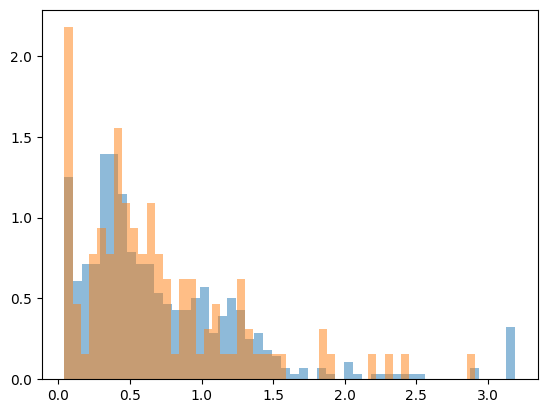

In [30]:
from matplotlib import pyplot as plt

fig, ax = plt.subplots()
ax.hist(train_losses, bins=50, alpha=0.5, density=True)
ax.hist(test_losses, bins=50, alpha=0.5, density=True)